# 试卷名：新课标 高考真题 【政治】学科

--------
## 题目编号：11（含图片）
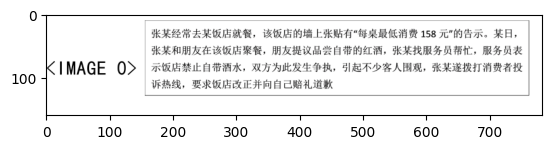
## 题目标答
①：饭店要求最低消费侵害了张某的自主选择权和公平交易的权利，不是知情权，①排除。③：格式条款是当事人为了重复使用而预先拟定，并在订立合同时未与对方协商的条款，是单方事先制定的，不能就合同条款进行协商的，设置最低消费属于典型的格式条款，③正确。②④：饭店禁止客人自带酒水，不是侵害了张某的名誉权，而是侵犯了消费者自主选择商品的权利，是不合法的。消费者享有自主选择商品或服务的权利，②错误，④正确。故本题选D。
## GLM4 4V 9B 模型输出
饭店要求最低消费侵害了张某的知情权，饭店禁止自带酒水侵害了张某的自主选择权，所以①④正确，所以选择B。


In [2]:
import re
import json
from PIL import Image, ImageDraw, ImageFont
import urllib
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import matplotlib.pyplot as plt
import os



device = torch.device("cuda")

model_path = "THUDM/glm-4v-9b"
gen_kwargs = {"max_length": 8192, "do_sample": False,"temperature":0.0}
model_name = "GLM4 4V 9B"
tokenizer = AutoTokenizer.from_pretrained(
    model_path, trust_remote_code=True,
)
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    trust_remote_code=True,
    torch_dtype=torch.float16,
).eval().to(device)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/15 [00:00<?, ?it/s]

试卷名：新课标 高考真题 【政治】学科


/root/miniconda3/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


***************
题目编号：11（含图片）


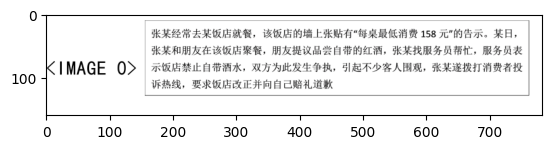

题目标答：①：饭店要求最低消费侵害了张某的自主选择权和公平交易的权利，不是知情权，①排除。③：格式条款是当事人为了重复使用而预先拟定，并在订立合同时未与对方协商的条款，是单方事先制定的，不能就合同条款进行协商的，设置最低消费属于典型的格式条款，③正确。②④：饭店禁止客人自带酒水，不是侵害了张某的名誉权，而是侵犯了消费者自主选择商品的权利，是不合法的。消费者享有自主选择商品或服务的权利，②错误，④正确。故本题选D。
GLM4 4V 9B 模型输出：饭店要求最低消费侵害了张某的知情权，饭店禁止自带酒水侵害了张某的自主选择权，所以①④正确，所以选择B。


In [3]:
def img_process(im_list):
    imgs = []
    for p in im_list:
        try:
            imgs.append(Image.open(p))
        except:
            return -1
    new_w = 0
    new_h = 0
    for im in imgs:
        w, h = im.size
        new_w = max(new_w, w)
        new_h += h + 20
    new_w += 20
    new_h += 20
    # new_w = max(512, new_w)
    # new_h = max(512, new_h)
    pad = max(new_w // 4, 100)
    font = ImageFont.truetype("src/fonts/SimHei font.ttf", pad // 5)
    new_img = Image.new('RGB', (new_w + pad, new_h), 'white')
    draw = ImageDraw.Draw(new_img)
    curr_h = 10
    for idx, im in enumerate(imgs):
        w, h = im.size
        if im.mode == 'RGBA':
            # 创建一个白色背景的图像
            background = Image.new('RGB', im.size, (255, 255, 255))
            background.paste(im, mask=im.split()[3])  # 使用透明度通道作为掩码
            im = background
        new_img.paste(im, (pad, curr_h))
        draw.text((0, curr_h + h // 2), f'<IMAGE {idx}>', font=font, fill='black')
        if idx + 1 < len(imgs):
            draw.line([(0, curr_h + h + 10), (new_w + pad, curr_h + h + 10)], fill='black', width=2)
        curr_h += h + 20
    return new_img


subject, paper_type = "政治", "新课标"
file_name = f"../data/{paper_type}/{subject}.jsonl"
pattern = r'<img .*?"/>'
mm_question_pattern = re.compile(pattern)
pattern = r'src=".*?"'
img_pattern =re.compile(pattern)
cache_dir = "./src/input/img"
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir, exist_ok=True)

questions = []

print(f"试卷名：{paper_type} 高考真题 【{subject}】学科")

with open(file_name, "r") as f:
    for idx, line in enumerate(f):
        data = json.loads(line)
        has_img, question = False, data['prompt']

        if '<img' in question:
            has_img = True
            imgs = mm_question_pattern.findall(question)
            im_list = []
            for i, img in enumerate(imgs):
                question = question.replace(img, f'<IMAGE {i}> ', 1)
                img = img_pattern.findall(img)
                assert len(img) == 1
                img = img[0].split('"')[1]
                cache_path = f"{cache_dir}/{subject}_{model_name.split()[0]}_{idx}_{i}.png"
                urllib.request.urlretrieve(img,cache_path)
                im_list.append(cache_path)
            img = img_process(im_list)

            inputs = tokenizer.apply_chat_template(
                [{"role": "user", "image": img, "content": question}],
                add_generation_prompt=True,
                tokenize=True,
                return_tensors="pt",
                return_dict=True
            )
            inputs = inputs.to(device)

            with torch.no_grad():
                outputs = model.generate(**inputs, **gen_kwargs)
                outputs = outputs[:, inputs['input_ids'].shape[1]:]

                response = tokenizer.decode(outputs[0], skip_special_tokens=True)

            if idx == 0:
                print("*" * 35)
            else:
                print("*" * 15)

            print("题目编号：" + str(idx + 1) + ("（含图片）" if has_img else ""))
            plt.imshow(img)
            plt.show()
            print("题目标答：" + data["answer"])
            print(f"{model_name} 模型输出：" + response)

            questions.append({
                "id": str(idx + 1),
                "question": data['prompt'],
                "answer": data["answer"],
                "output": response,
                "has_img": has_img
            })